<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula09a_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-10-20 23:29:56--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.203.205, 52.217.85.62, 52.217.198.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.203.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  22.1MB/s    in 0.6s    

2025-10-20 23:29:56 (22.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data  = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]
raw_data.shape

(420451, 14)

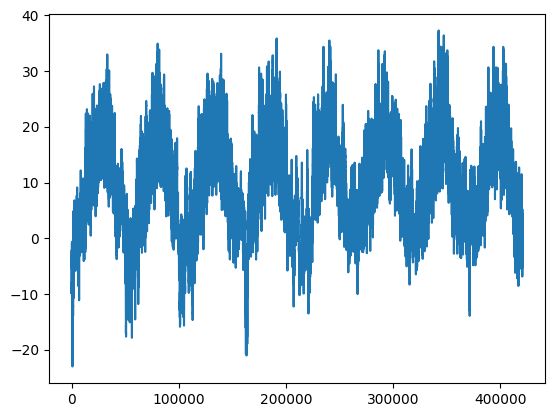

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

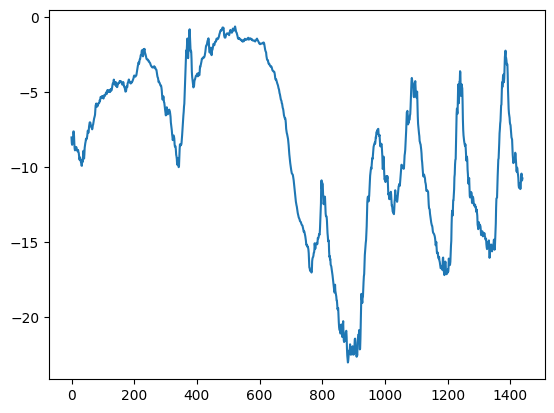

In [5]:
tendays = 6*24*10 # each 10 minutes 1 reading
plt.plot(range(tendays), temperature[:tendays])
plt.show()

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
    shuffle=True
)
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))
  print()

[2, 3, 4] 5
[3, 4, 5] 6

[4, 5, 6] 7
[1, 2, 3] 4

[0, 1, 2] 3



In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [10]:
print(delay, delay/6, ((delay/6)+1)/24)

858 143.0 6.0


In [11]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


#baseline

In [12]:
def evalute_naive_method(dataset):
  total_abs_err = 0
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print("Validation MAE (naive method):", evalute_naive_method(val_dataset))
print("Test MAE (naive method):", evalute_naive_method(test_dataset))

Validation MAE (naive method): 2.4417326002413837
Test MAE (naive method): 2.622035888818065


#densely connected

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
x = layers.Reshape((-1, sequence_length*raw_data.shape[-1]))(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 85.1826 - mae: 7.4531 - val_loss: 70.0154 - val_mae: 6.8674
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 77.7137 - mae: 7.1407 - val_loss: 66.4493 - val_mae: 6.7036
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 77.2101 - mae: 7.1197 - val_loss: 67.4756 - val_mae: 6.7540
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 76.8301 - mae: 7.1030 - val_loss: 69.3577 - val_mae: 6.8425
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 76.7338 - mae: 7.0990 - val_loss: 65.0492 - val_mae: 6.6306
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - loss: 76.7201 - mae: 7.0980 - val_loss: 67.7353 - val_mae: 6.7678
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 76.6811 - mae: 7.0965 - val_loss: 65.1243 - val_mae: 6.6287
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - loss: 76.6305 - mae: 7.0940 - val_loss: 64.9864 - val_mae: 6.6250
Epoch 9/10
819/819 ━━━━━

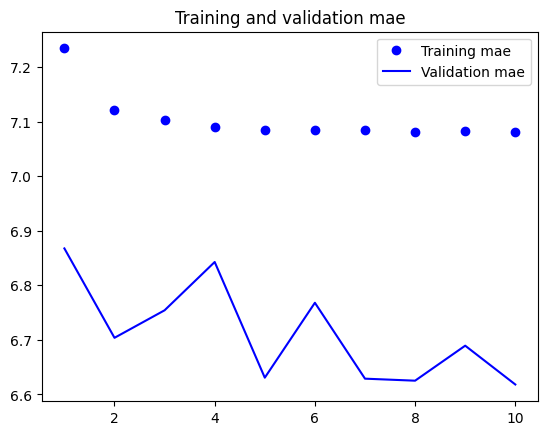

In [14]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure
plt.plot(epochs, loss, 'bo', label='Training mae')
plt.plot(epochs, val_loss, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.show()

#1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 31.4607 - mae: 4.2443 - val_loss: 15.1024 - val_mae: 3.0954
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 78s 53ms/step - loss: 15.2400 - mae: 3.0924 - val_loss: 16.9554 - val_mae: 3.2574
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - loss: 13.7604 - mae: 2.9312 - val_loss: 14.3900 - val_mae: 2.9932
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.9032 - mae: 2.8387 - val_loss: 13.6324 - val_mae: 2.9127
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.3066 - mae: 2.7718 - val_loss: 14.8468 - val_mae: 3.0498
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.7889 - mae: 2.7092 - val_loss: 14.2319 - val_mae: 2.9527
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 11.3123 - mae: 2.6551 - val_loss: 13.6007 - val_mae: 2.9001
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 10.9230 - mae: 2.6078 - val_loss: 15.5245 - val_mae: 3.1101
Epoch 9/10
819/819 ━━━━━

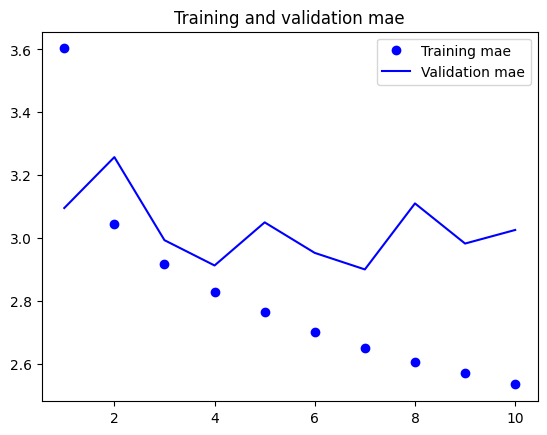

In [16]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure
plt.plot(epochs, loss, 'bo', label='Training mae')
plt.plot(epochs, val_loss, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.show()

#Recurrent Network

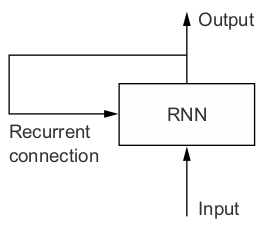

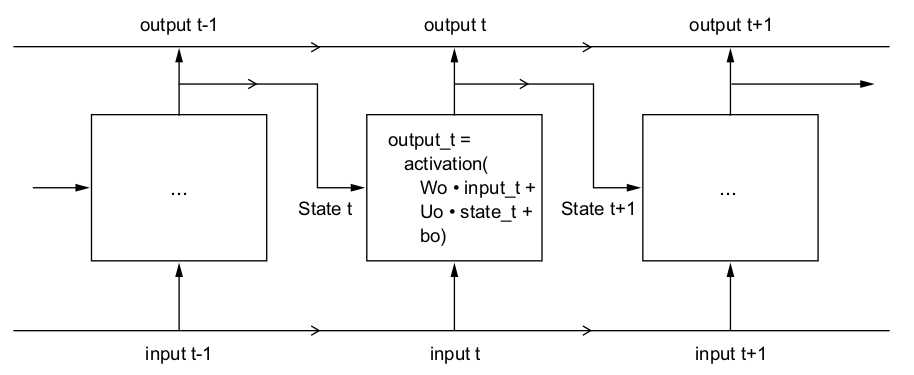

#LSTM

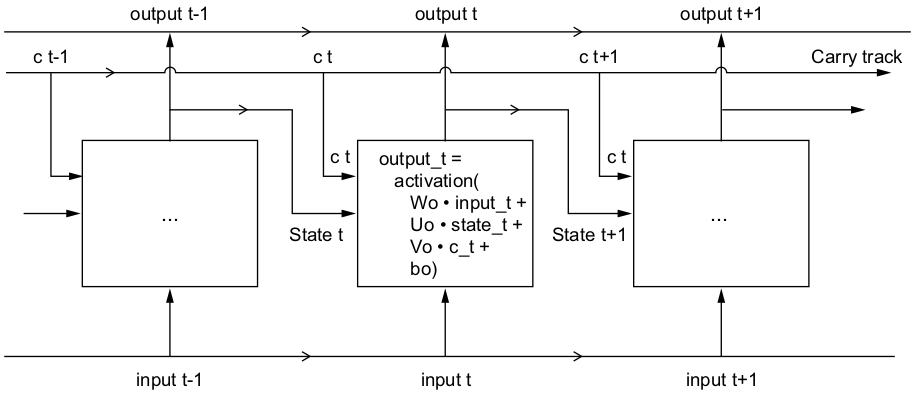

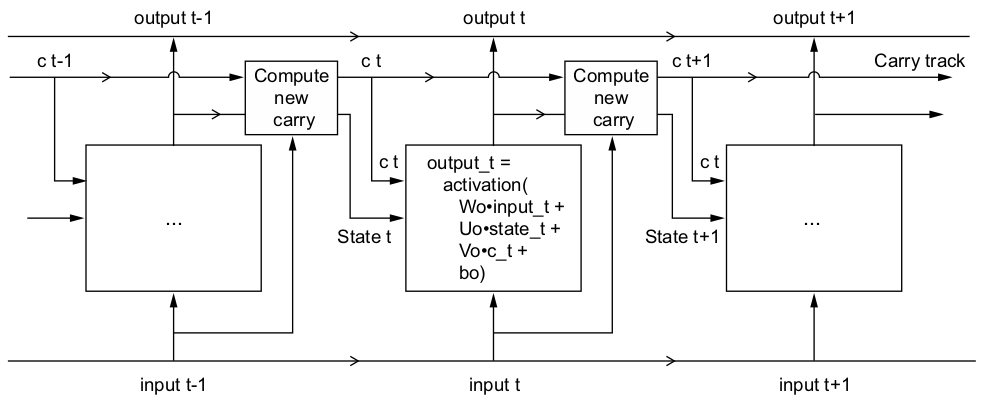

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - loss: 75.5749 - mae: 6.6824 - val_loss: 13.4902 - val_mae: 2.7779
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 12.3537 - mae: 2.7057 - val_loss: 11.1729 - val_mae: 2.4940
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 10.2185 - mae: 2.4898 - val_loss: 9.2990 - val_mae: 2.3763
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 9.6983 - mae: 2.4264 - val_loss: 9.2082 - val_mae: 2.3677
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - loss: 9.3276 - mae: 2.3754 - val_loss: 9.2723 - val_mae: 2.3739
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 9.0147 - mae: 2.3321 - val_loss: 9.4445 - val_mae: 2.3955
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 8.7415 - mae: 2.2965 - val_loss: 10.1370 - val_mae: 2.4578
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - loss: 8.5328 - mae: 2.2714 - val_loss: 10.0195 - val_mae: 2.4583
Epoch 9/10
819/819 ━━━━━━━━━━━━━━

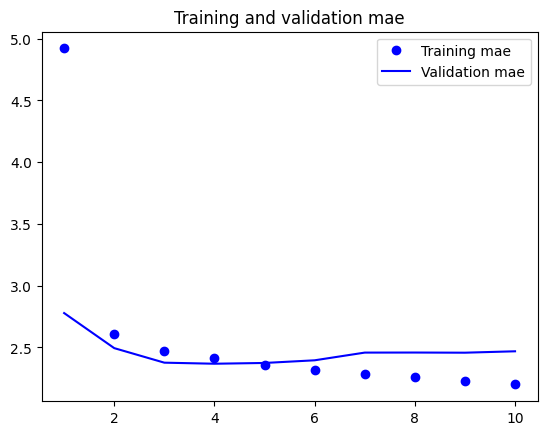

In [18]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure
plt.plot(epochs, loss, 'bo', label='Training mae')
plt.plot(epochs, val_loss, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#Stacking recurrent layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#bidirectional LSTM

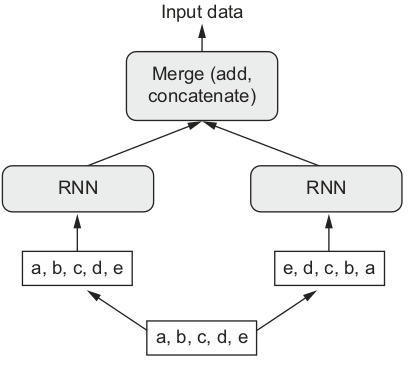

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_bidirectional.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - loss: 54.1209 - mae: 5.4258 - val_loss: 10.6404 - val_mae: 2.5259
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 9.7239 - mae: 2.4344 - val_loss: 9.6831 - val_mae: 2.4180
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 8.6112 - mae: 2.2778 - val_loss: 9.7627 - val_mae: 2.4300
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 8.1180 - mae: 2.2112 - val_loss: 9.8272 - val_mae: 2.4406
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 7.7323 - mae: 2.1632 - val_loss: 10.0104 - val_mae: 2.4650
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 7.3684 - mae: 2.1128 - val_loss: 10.0645 - val_mae: 2.4744
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 7.0858 - mae: 2.0729 - val_loss: 10.1912 - val_mae: 2.4987
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 6.8515 - mae: 2.0401 - val_loss: 10.0829 - val_mae: 2.4719
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

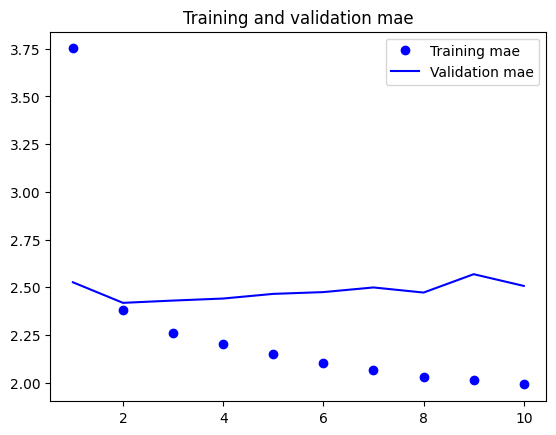

In [21]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure
plt.plot(epochs, loss, 'bo', label='Training mae')
plt.plot(epochs, val_loss, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.show()